In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.relativedelta import *

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# We can also use inspector to get the table names from hawaii database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [25]:
# Let's get the available range of dates
#Check the range of dates in Measurement table
engine.execute("SELECT MIN(date), MAX(date) FROM Measurement").first()

('2010-01-01', '2017-08-23')

In [26]:
# Same can be achieved using
result = session.query(func.max(Measurement.date).label("max_date"),
              func.min(Measurement.date).label("min_date")).first()
for r in result:
    max_date = result[0]
    min_date = result[1]
print (f"Earliest available date  is '{min_date}', Latest available date is '{max_date}")

Earliest available date  is '2010-01-01', Latest available date is '2017-08-23


In [27]:
# Let's say my vacation is planned for 15 days, and assuming my date of return is 2017-08-23 get the start date
# My query should be
vacation_end_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
# Get the start date using end date and number of days of travel
num_days = 15
vacation_start_date = vacation_end_date - dt.timedelta(days=num_days)
# Following query gets the dates for my vacation 
vacation_period = session.query(Measurement.date).\
                    filter(Measurement.date >= vacation_start_date).\
                    filter(Measurement.date <= vacation_end_date).\
                    group_by(Measurement.date).\
                    order_by(Measurement.date).all()
vacation_period

[('2017-08-09'),
 ('2017-08-10'),
 ('2017-08-11'),
 ('2017-08-12'),
 ('2017-08-13'),
 ('2017-08-14'),
 ('2017-08-15'),
 ('2017-08-16'),
 ('2017-08-17'),
 ('2017-08-18'),
 ('2017-08-19'),
 ('2017-08-20'),
 ('2017-08-21'),
 ('2017-08-22'),
 ('2017-08-23')]

# Exploratory Climate Analysis

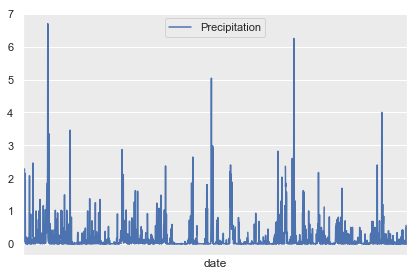

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#start_date = end_date - relativedelta(months=12) # References say that this computes the accurate dates gets data for 365 days and hence we get count as 2015
end_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
prcp_result = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.DataFrame(prcp_result)

#prcp_data.set_index('date', inplace=True)
#prcp_data
#The commented lines should be done to ensure we have clean data. Not opting to do to match the results.
# Drop NaN values
#--prcp_data = prcp_data.dropna() ##Doesn't change the result in any big way!
# A quick check to confirm we have dropped NaNs from our data
#--prcp_data.isna()
# Drop duplicate rows
#--prcp_data = prcp_data.drop_duplicates()
sns.set()
sns.set_style({'grid.linewidth': .2, 'axes.grid': True,
                                'axes.facecolor': '.92'})
prcp_data.plot('date','prcp')
plt.legend(labels=['Precipitation'], loc="upper center")
plt.xticks([])
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe() ## Note the result shown has 2021 as count and mean, std different

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [30]:
# Design a query to show how many stations are available in this dataset
total_stations = session.query(func.count(Station.id)).all()
total_stations

[(9)]

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
summary_station_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),
                                      func.avg(Measurement.tobs)).group_by(Measurement.station).\
                                        order_by(func.count(Measurement.tobs).desc()).first()

print(f'\nQuick summary of temperatures from the most active station {summary_station_temps[0]}')
print(f'----------------------------------------------------------------------\n')
print(f'\nLowest temperature recorded was\t\t: {summary_station_temps[1]}\n')
print(f'\nHighest temperature recorded was\t: {summary_station_temps[2]}\n')
print(f'\nAverage temperature recorded was\t: {summary_station_temps[3]}\n')


Quick summary of temperatures from the most active station USC00519281
----------------------------------------------------------------------


Lowest temperature recorded was		: 54.0


Highest temperature recorded was	: 85.0


Average temperature recorded was	: 71.66378066378067



In [33]:
# Choose the station with the highest number of temperature observations.
station_with_highest_num_of_obs = session.query(Measurement.station).group_by(Measurement.station).\
                                        order_by(func.count(Measurement.tobs).desc()).limit(1).first()
station_with_highest_num_of_obs[0]

'USC00519281'

In [34]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_end_date = session.query(func.max(Measurement.date)).\
                filter(Measurement.station == station_with_highest_num_of_obs[0]).first()

# Convert the query result into a datetime object
obs_end_date = dt.datetime.strptime(obs_end_date[0], '%Y-%m-%d')

#obs_end_date # This date is 2017-08-08

# Get the date starting which the precipitations have to be plotted (12 months before the end date). 
# Uses relativedelta from dateutils module.  Learned that there aren't any direct methods in basic python libraries and the
# timedelta from datetime isn't accurate given that the number of days could vary for each month in a given year. relativedelta
# accounts for leap years as well.

obs_start_date =  obs_end_date - dt.timedelta(days=366)
#obs_start_date # This date is 2016-08-19

# Perform a query to retrieve the data and precipitation scores for the station 'USC00519281', the station that recorded the
# highest number of observations.
# If we select "Measurement.station, Measurement.date, Measurement.tobs, func.count(Measurement.tobs).label('frequency')", we can
# see the data we are working with...
## Station_with_highest_num_of_obs[0], 'USC00519397', 'USC00513117','USC00519523', 'USC00516128', 
##'USC00514830', 'USC00511918'(this station seem to have duplicates),'USC00517948', 'USC00518838' (*has duplicates)
station_with_highest_obs_result_grpd = session.query(Measurement.station, Measurement.date, Measurement.tobs, func.count(Measurement.tobs).label('frequency')).\
                                    filter(Measurement.date >= obs_start_date).\
                                    filter(Measurement.station == station_with_highest_num_of_obs[0]).\
                                    group_by(Measurement.tobs).\
                                    order_by(func.count(Measurement.tobs)).all()
station_with_highest_obs_result = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                                    filter(Measurement.date >= obs_start_date).\
                                    filter(Measurement.station == station_with_highest_num_of_obs[0]).\
                                    order_by(Measurement.tobs).all()

station_with_highest_obs_result

[('USC00519281', '2017-02-02', 59.0),
 ('USC00519281', '2017-02-08', 59.0),
 ('USC00519281', '2017-02-09', 59.0),
 ('USC00519281', '2017-02-03', 60.0),
 ('USC00519281', '2017-04-30', 60.0),
 ('USC00519281', '2017-02-25', 61.0),
 ('USC00519281', '2016-12-15', 62.0),
 ('USC00519281', '2017-01-06', 62.0),
 ('USC00519281', '2017-01-09', 62.0),
 ('USC00519281', '2017-01-10', 62.0),
 ('USC00519281', '2017-02-10', 62.0),
 ('USC00519281', '2017-03-07', 62.0),
 ('USC00519281', '2016-11-07', 63.0),
 ('USC00519281', '2017-01-04', 63.0),
 ('USC00519281', '2017-01-05', 63.0),
 ('USC00519281', '2017-01-11', 63.0),
 ('USC00519281', '2017-01-03', 64.0),
 ('USC00519281', '2017-02-07', 64.0),
 ('USC00519281', '2017-03-08', 64.0),
 ('USC00519281', '2016-12-13', 65.0),
 ('USC00519281', '2017-01-12', 65.0),
 ('USC00519281', '2017-01-28', 65.0),
 ('USC00519281', '2017-02-16', 65.0),
 ('USC00519281', '2017-02-27', 65.0),
 ('USC00519281', '2017-03-18', 65.0),
 ('USC00519281', '2017-05-01', 65.0),
 ('USC005192

In [35]:
# Save the query results as a Pandas DataFrame and set the index to the date column
temperature_data = pd.DataFrame(station_with_highest_obs_result)
#temperature_data = temperature_data.sort_values(by=['tobs'], ascending=False)
temperature_data

,station,date,tobs
0,USC00519281,2017-02-02,59.0
1,USC00519281,2017-02-08,59.0
2,USC00519281,2017-02-09,59.0
3,USC00519281,2017-02-03,60.0
4,USC00519281,2017-04-30,60.0
5,USC00519281,2017-02-25,61.0
6,USC00519281,2016-12-15,62.0
7,USC00519281,2017-01-06,62.0
8,USC00519281,2017-01-09,62.0
9,USC00519281,2017-01-10,62.0


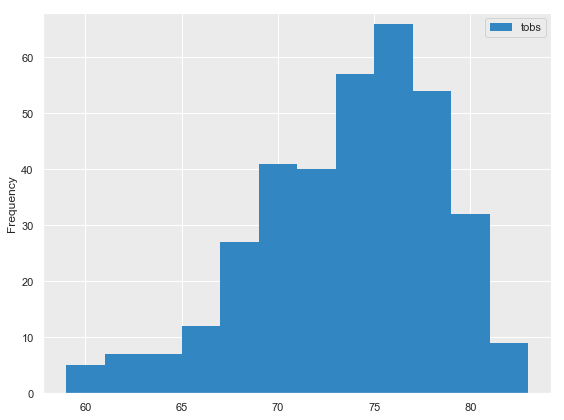

In [36]:
# Let's plot our histogram
# Initialize the plot using figure area and axes
fig, ax = plt.subplots(figsize=(8,6))
temperature_data.tobs.hist(bins=12, label='tobs', color='#3286c1', linewidth=0)
plt.ylim(0,68,10)
ax.set_ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# A reminder about my period of vacation...
vacation_start_date_copy = vacation_start_date.strftime('%Y-%m-%d')
vacation_end_date_copy = vacation_end_date.strftime('%Y-%m-%d')
print(f'My vacation period is from %s, to %s' %(vacation_start_date_copy, vacation_end_date_copy))

My vacation period is from 2017-08-08, to 2017-08-23


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# To get the previous year's data,
vacation_end_date_prev_year = (vacation_end_date - dt.timedelta(days=365))
vacation_end_date_prev_year_copy = vacation_end_date_prev_year.strftime('%Y-%m-%d')
vacation_start_date_prev_year = (vacation_start_date - dt.timedelta(days=366))
vacation_start_date_prev_year_copy = vacation_start_date_prev_year.strftime('%Y-%m-%d')
print(f'Same vacation period from previous year will be between %s and %s dates' %(vacation_start_date_prev_year_copy, vacation_end_date_prev_year_copy))

Same vacation period from previous year will be between 2016-08-07 and 2016-08-23 dates


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
print(calc_temps(vacation_start_date_prev_year, vacation_end_date_prev_year))

[(71.0, 78.3047619047619, 83.0)]


In [41]:
# Because the bar chart is about the vacation period, we shall compute the temperatures
# for the vacation which is not quite obvious in the problem definition...
# Convert the result obtained in a dataframe for easy plotting
computed_weather = calc_temps(vacation_start_date, vacation_end_date)
weather_attributes = ['tmin','tavg','tmax']
trip_weather = pd.DataFrame(computed_weather, columns = weather_attributes) 
trip_weather

,tmin,tavg,tmax
0,70.0,78.644068,85.0


In [42]:
# Let's get the weather data for the vacation period
trip_weather_result = session.query(Measurement.date, Measurement.tobs).\
                                    filter(Measurement.date >= vacation_start_date).\
                                    filter(Measurement.date <= vacation_end_date).\
                                    order_by(Measurement.tobs).all()
trip_weather_data = pd.DataFrame(trip_weather_result, columns=['date','tobs'])
trip_weather_data = trip_weather_data.sort_values(by='date', ascending=False) # .nunique() on this gives 15, and it matches with the numer of vacation days
trip_weather_data

,date,tobs
51,2017-08-23,82.0
54,2017-08-23,82.0
41,2017-08-23,81.0
14,2017-08-23,76.0
53,2017-08-22,82.0
13,2017-08-22,76.0
48,2017-08-22,82.0
25,2017-08-21,79.0
52,2017-08-21,82.0
40,2017-08-21,81.0


In [43]:
trip_weather

,tmin,tavg,tmax
0,70.0,78.644068,85.0


In [44]:
trip_weather_statistics = trip_weather_data.describe()
trip_weather_statistics

,tobs
count,59.000000
mean,78.644068
std,3.477825
min,70.000000
25%,76.500000
50%,79.000000
75%,81.000000
max,85.000000


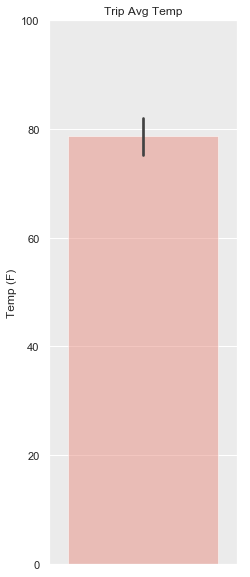

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(3,10)
ax = sns.barplot(y="tobs", data=trip_weather_data, color='salmon', alpha=0.5, ci="sd")
plt.ylim (0,100,20)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

In [46]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year_rainfall_result = session.query(Measurement.station, Station.name, (Measurement.prcp).label('rain'), Station.latitude, 
                                          Station.longitude, Station.elevation).\
                                    filter(Measurement.date >= vacation_start_date_prev_year).\
                                    filter(Measurement.date <= vacation_end_date_prev_year).\
                                    filter(Measurement.station == Station.station).\
                                    order_by(Measurement.prcp).all()
prev_year_rainfall_data = pd.DataFrame(prev_year_rainfall_result, columns=['station','name','rain','latitude','longitude','elevation'])
prev_year_rainfall_data = prev_year_rainfall_data.dropna()
rainfall_per_station = pd.pivot_table(prev_year_rainfall_data, index=['station'], values=['rain'], aggfunc=sum)
rainfall_per_station.sort_values(by='rain', ascending=False)

,rain
station,
USC00516128,10.00
USC00519281,5.80
USC00513117,2.44
USC00519523,0.85
USC00519397,0.58
USC00514830,0.28
USC00517948,0.00


## Optional Challenge Assignment

In [100]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


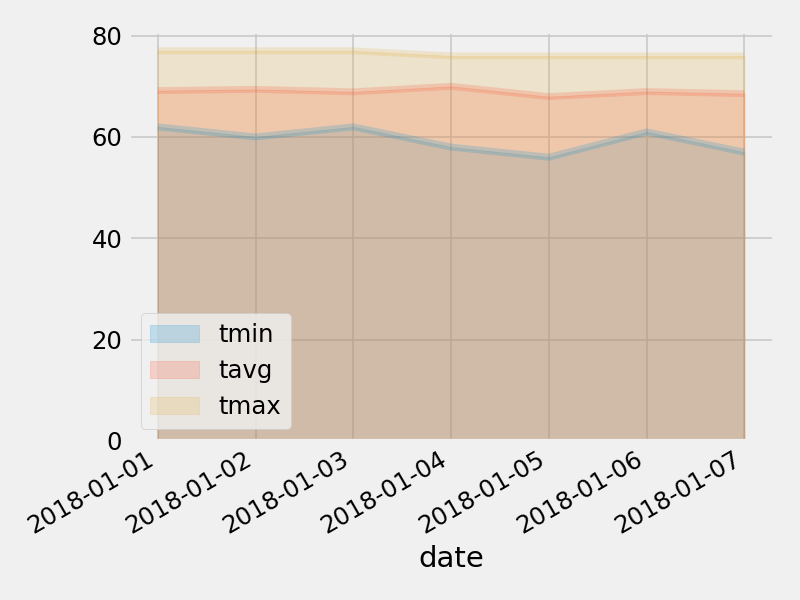

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
